In [122]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 

import string
import re
from datetime import datetime

import nltk

In [123]:
df = pd.read_csv('tshirt_reviews.csv')

In [124]:
df.head()

,author,date,title,rating,body,helpful,verified_purchase
0,Andy's Reviews,"Reviewed in Canada on November 30, 2019",Shirt as dark as the future of Earth,5.0,I bought these shirts because the graphic tees...,508,1
1,Delvaille,"Reviewed in Canada on April 27, 2019",Good product!,5.0,I really like the length of the shirt. Long en...,163,1
2,AXE,"Reviewed in Canada on August 15, 2018","I am typically a medium, and the reviews said ...",5.0,"I am typically a medium, and the reviews said ...",122,1
3,VT,"Reviewed in Canada on May 2, 2020",Good shirt for the price,4.0,I ordered these to wear while I workout and do...,58,1
4,Hava,"Reviewed in Canada on September 9, 2018",Check the collar for a label printed on it.,3.0,I purchased these t shirts I my hi and toner t...,74,1


In [125]:
df.columns
df.dtypes

author                object
date                  object
title                 object
rating               float64
body                  object
helpful               object
verified_purchase      int64
dtype: object

All the object data type will be converted in proper types later

In [141]:
#Searching for null values and replace it with white space
df = df.fillna(' ')
#df = df.dropna()

There are 2 null values from the body column, however, the title column will be combined with body in text preprocessing, as title column has no null value, the combined column won't have any null value.

In [128]:
#Columns that are in object type have to be changed to proper types
#Author, title, body to string type, date to datetime type, rating, helpful to float/int type
df[['author', 'title', 'body']] = df[['author', 'title', 'body']].astype('string')

#Helpful column
#There exist string "One person found this helpful" in some rows, which needs to be cleaned
df['helpful'] = df['helpful'].replace([',','One person found this helpful'],['','1'], regex=True)

df['helpful'] = pd.to_numeric(df['helpful'])

#Date column
#Extract date from string in date column
def split_date(text):   
    date=""
    string=text.split()
    date = date + string[4] + string[5] + string[6]
    date = pd.to_datetime(date, format='%B%d,%Y')
    return date

df['datetime'] = df['date'].apply(split_date) #datetime will be in datetime type
df = df.drop('date', axis=1) #drop date column as we don't need it in further steps anymore
df.dtypes

author                       string
title                        string
rating                      float64
body                         string
helpful                       int64
verified_purchase             int64
datetime             datetime64[ns]
dtype: object

In [129]:
#Rating column
#Modify it so that it only contains Positive 1, Negative -1 and Neural 0
def partition(rating):
    if rating > 3:
        return 1
    elif rating < 3:
        return -1
    else:
        return 0
df['polarity'] = df['rating'].map(partition)
df = df.drop('rating', axis=1) #drop rating column as we don't need it in further steps anymore
df.head()

,author,title,body,helpful,verified_purchase,datetime,polarity
0,Andy's Reviews,Shirt as dark as the future of Earth,I bought these shirts because the graphic tees...,508,1,2019-11-30,1
1,Delvaille,Good product!,I really like the length of the shirt. Long en...,163,1,2019-04-27,1
2,AXE,"I am typically a medium, and the reviews said ...","I am typically a medium, and the reviews said ...",122,1,2018-08-15,1
3,VT,Good shirt for the price,I ordered these to wear while I workout and do...,58,1,2020-05-02,1
4,Hava,Check the collar for a label printed on it.,I purchased these t shirts I my hi and toner t...,74,1,2018-09-09,0


## Brief EDA analysis to see how our dataset looks like

<function matplotlib.pyplot.show(close=None, block=None)>

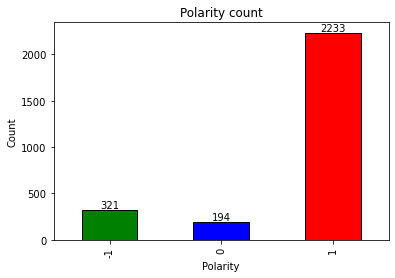

In [130]:
#Polarity
fig, ax = plt.subplots()
df['polarity'].value_counts().sort_index().plot(ax=ax, kind='bar', color=['green', 'blue', 'red'], edgecolor='black')
for bars in ax.containers:
    ax.bar_label(bars)
plt.title('Polarity count')
plt.xlabel('Polarity')
plt.ylabel('Count')
plt.show

In [131]:
df['datetime'].value_counts()

2021-03-30    10
2021-02-19    10
2019-12-05     9
2021-01-30     9
2020-12-30     9
              ..
2021-01-11     1
2018-11-30     1
2018-10-22     1
2022-04-07     1
2022-05-14     1
Name: datetime, Length: 1150, dtype: int64

We can see that our rating is highly imbalanced, where we have over 2000 positive rating comparing to only 321 negative values, this would have to be taken in account when training.

<function matplotlib.pyplot.show(close=None, block=None)>

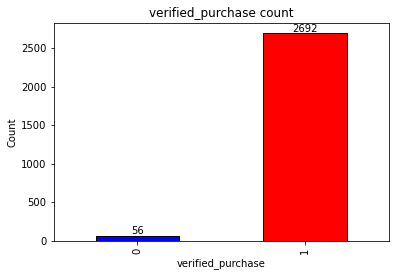

In [132]:
#Verified purchase
fig, ax = plt.subplots()
df['verified_purchase'].value_counts().sort_index().plot(ax=ax, kind='bar', color=['blue', 'red'], edgecolor='black')
for bars in ax.containers:
    ax.bar_label(bars)
plt.title('verified_purchase count')
plt.xlabel('verified_purchase')
plt.ylabel('Count')
plt.show

Only 56 purchases are not verified

In [133]:
#
df['COUNTER'] =1
df.groupby(['verified_purchase', 'polarity'])['COUNTER'].sum()

verified_purchase  polarity
0                  -1            16
                    0             5
                    1            35
1                  -1           305
                    0           189
                    1          2198
Name: COUNTER, dtype: int64

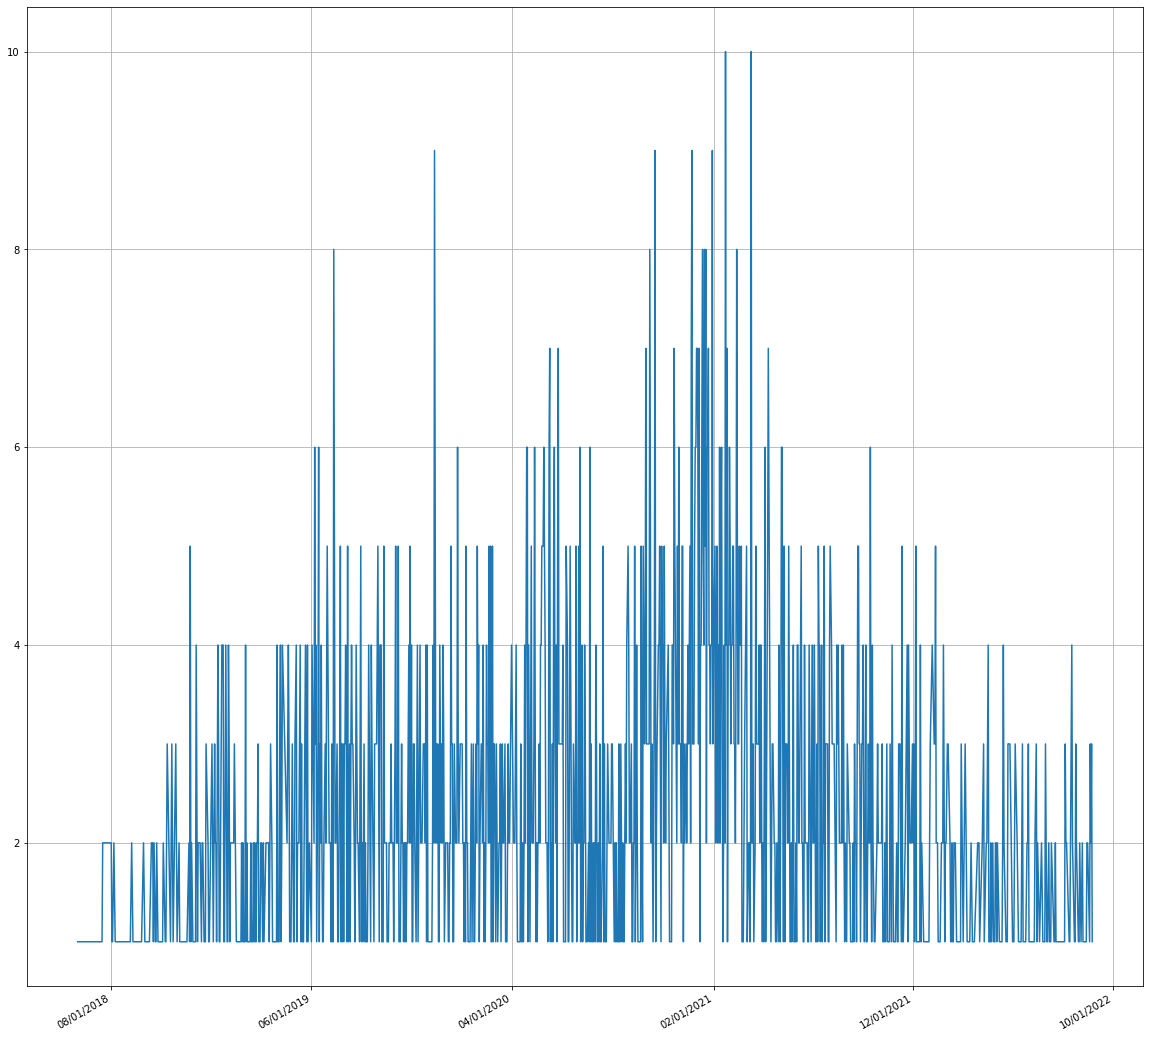

In [134]:
#See how many helpful reviews from each ratings
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(20, 20))

df['datetime'].value_counts().sort_index().plot(ax=ax)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=10))
plt.gcf().autofmt_xdate()
plt.grid(True)
plt.show()

## Data cleaning

In [139]:
#Let's extract the only columns that we need from the dataset for the nlp reviews
from nltk.corpus import stopwords                  
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from langdetect import detect
from deep_translator import GoogleTranslator
import emoji

punctuation_list = '!"#$%&\'()*+,./:;<=>?@[\]^_`{|}~'

final_data = pd.DataFrame().assign(polarity=df['polarity'], text=(df['title']+' '+df['body']))

#stopwords
stop = set(stopwords.words('english')) 
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stop])

#Translation into English
def non_english_remove(text):
    review = ""
    if detect(text) != 'en':
        review = GoogleTranslator(source='auto', target='en').translate(text=text)
    else:
        review = text
    return review

#Stemming
stemmer = PorterStemmer()
def stem_words(text):
    return " ".join([stemmer.stem(word) for word in text.split()])

#Lemmatization
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

#Non-english word treatment
def non_english_remove(text):
    return " ".join([word for word in str(text).split() if detect(text) != 'en'])

def text_preprocess(text):
    text = text.lower() #lowercase text
    text = text.apply(lambda x: emoji.demojize(x)) #Replace emoji with emoji shortcodes
    text = text.apply(lambda x: re.sub(r'\w*\d\w*','',x)) #Remove digits and words containing digits
    text = text.apply(lambda x: re.sub(r'[A-Za-z0-9]*@[A-Za-z]*\.?[A-Za-z0-9]*', '',x)) #Remove email-id
    text = text.apply(lambda x: re.sub(r'\s*https?://\S+(\s+|$)', '', x)) #Remove url
    text = text.apply(lambda x: re.sub('[%s]' % re.escape(punctuation_list), '' , x)) #Remove punctuation
    text = text.apply(lambda x: re.sub(r' +', ' ', x)) #Remove extra space
    text = text.apply(lambda x: remove_stopwords(x)) #Remove stopwords


In [238]:
from langdetect import detect, DetectorFactory, detect_langs
from deep_translator import GoogleTranslator
import emoji

def non_english_remove(text):
    review = ""
    if detect(text) != 'en':
        review = GoogleTranslator(source='auto', target='en').translate(text=text)
    else:
        review = text
    return review

final_data1 = pd.DataFrame().assign(polarity=df['polarity'], text=(df['title']+' '+df['body']))
final_data1.text = final_data1.text.apply(lambda x: emoji.demojize(x))
final_data1.text = final_data1.text.apply(lambda x: non_english_remove(x))
final_data1


,polarity,text
0,1,None
1,1,None
2,1,None
3,1,None
4,0,None
...,...,...
2743,1,Very good quality I have already bought this p...
2744,1,Great deal Great deal
2745,1,None
2746,1,None


In [235]:
stringe = '👍 👍'
def remove_emoji(text):
    return emoji.demojize(text)
print(remove_emoji(stringe))

:thumbs_up: :thumbs_up:


In [211]:
from deep_translator import GoogleTranslator
review = GoogleTranslator(source='auto', target='en').translate(text='我好饿')
print(review)

I'm very hungry


### Text cleaning

In [136]:
#observe that some of the text are in different language
#Using textblob for language detection andtranslating into english
from langdetect import detect

final_X = []

count = 0
for text in final_X_raw:
    try:
        if detect(text) != 'en':
            count+= 1
    except:
        continue

print(count)


565


In [ ]:
#Now it's time to pre-process title and body for NLP analysis
from nltk.corpus import stopwords                  
from nltk.stem import PorterStemmer

#stopwords
stop = set(stopwords.words('english')) 
snow = nltk.stem.SnowballStemmer('english')

#cleaning unwanted punctuations or signs
temp =[]
for sentence in final_X_raw:
    sentence = sentence.lower()                 # Converting to lowercase
    sentence = re.sub(r'[?|!|\'|"|#|:]',r'',sentence)
    sentence = re.sub(r'[.|,|)|(|\|/]',r' ',sentence)        #Removing Punctuations
    temp.append(sentence)
temp
    

